In [9]:
from astropy.io import fits
from astropy.table import Table, join, unique, vstack, hstack
import pyphot

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from pyvo import registry  # version >=1.4.1 
from astroquery.gaia import Gaia

plt.style.use('stefan.mplstyle')

In [10]:
catalog = Table.read('data/1710105466553A.csv')

In [11]:
stardats = []
iters = (len(catalog)+2000) // 2000

for i in tqdm(range(iters)):
        ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
        FROM gaiadr3.gaia_source as gaia
        JOIN external.gaiaedr3_distance as dist
        ON gaia.source_id = dist.source_id      
        WHERE gaia.source_id in {}""".format(tuple(catalog['GaiaEDR3'][2000*i:2000*i+2000]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
        
gaia_d1 = vstack(stardats)

100%|██████████| 115/115 [02:53<00:00,  1.51s/it]


In [12]:
catalog.rename_column('GaiaEDR3', 'source_id')
catalog = join(catalog, gaia_d1, keys = 'source_id')

In [13]:
catalog = catalog[catalog['r_med_geo'] < 200]

In [14]:
lib = pyphot.get_library()
f = [lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]

catalog['w1snr'] = catalog['FW1'] / catalog['e_FW1']
catalog['w2snr'] = catalog['FW2'] / catalog['e_FW2']

catalog['w1mpro'] = -2.5 * np.log10(2.99792458e-5 * 309.05e-9 * catalog['FW1'] / f[0].lpivot.to('angstrom').value**2) - f[0].Vega_zero_mag
catalog['w2mpro'] = -2.5 * np.log10(2.99792458e-5 * 167.66e-9 * catalog['FW2'] / f[1].lpivot.to('angstrom').value**2) - f[1].Vega_zero_mag

catalog['w1sigm'] = catalog['e_FW1'] / (1.09 * catalog['FW1'])
catalog['w2sigm'] = catalog['e_FW2'] / (1.09 * catalog['FW2'])

<ipython-input-14-4acc9ea9cecd>:4: RuntimeWarning: invalid value encountered in true_divide
  catalog['w1snr'] = catalog['FW1'] / catalog['e_FW1']
<ipython-input-14-4acc9ea9cecd>:5: RuntimeWarning: invalid value encountered in true_divide
  catalog['w2snr'] = catalog['FW2'] / catalog['e_FW2']
<ipython-input-14-4acc9ea9cecd>:7: RuntimeWarning: divide by zero encountered in log10
  catalog['w1mpro'] = -2.5 * np.log10(2.99792458e-5 * 309.05e-9 * catalog['FW1'] / f[0].lpivot.to('angstrom').value**2) - f[0].Vega_zero_mag
<ipython-input-14-4acc9ea9cecd>:8: RuntimeWarning: divide by zero encountered in log10
  catalog['w2mpro'] = -2.5 * np.log10(2.99792458e-5 * 167.66e-9 * catalog['FW2'] / f[1].lpivot.to('angstrom').value**2) - f[1].Vega_zero_mag
<ipython-input-14-4acc9ea9cecd>:10: RuntimeWarning: invalid value encountered in true_divide
  catalog['w1sigm'] = catalog['e_FW1'] / (1.09 * catalog['FW1'])
<ipython-input-14-4acc9ea9cecd>:11: RuntimeWarning: invalid value encountered in true_divide

In [15]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pyphot
import extinction

#catalog['r_med_geo'] = 100 / catalog['PARALLAX']

# Coordinates using inverted parallax distances
coords = [SkyCoord(frame="icrs", ra=catalog['RAdeg'][i]*u.deg, dec=catalog['DEdeg'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords


# Query Edenhofer2023 to get E(B-V) in arbitrary units
bsq = Edenhofer2023Query()
bsq_res = bsq.query(catalog['wd_coords']).copy()
bsq_res[np.isnan(bsq_res)] = 0

# Convert to actual units
Ebv = bsq_res*0.901*0.98
e_Ebv = Ebv*0.2

catalog['E(B-V)'] = Ebv
catalog['e_E(B-V)'] = e_Ebv


# Parameters for correcting using Gaia
Rv = 3.1
catalog['A_v0'] = catalog['E(B-V)']*Rv

# Fetch Gaia photometric band wavelengths and store in `gaia_phot_wavl`
lib = pyphot.get_library()
gaia_phot = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP'], lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]
gaia_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in gaia_phot])


# For each point, find extinction using the parameters we defined above
ext_all = []
for av0 in catalog['A_v0']:
    ext_all.append( extinction.fitzpatrick99(gaia_phot_wavl, av0, Rv) )
ext_all = np.array(ext_all)
    
# Save the extinction in each band
catalog['G_ext'] = ext_all.T[0]
catalog['BP_ext'] = ext_all.T[1]
catalog['RP_ext'] = ext_all.T[2]
catalog['W1_ext'] = ext_all.T[1]
catalog['W2_ext'] = ext_all.T[1]


# Subtract out the extinction to find de-reddened magnitude
catalog['GAIA_G'] = catalog['Gmag'] - catalog['G_ext']
catalog['GAIA_BP'] = catalog['BPmag'] - catalog['BP_ext']
catalog['GAIA_RP'] = catalog['RPmag'] - catalog['RP_ext']
catalog['WISE_W1'] = catalog['w1mpro'] - catalog['W1_ext']
catalog['WISE_W2'] = catalog['w2mpro'] - catalog['W2_ext']

Optimizing map for querying (this might take a couple of seconds)...


In [16]:
catalog['abs_g'] = catalog['GAIA_G'] - 5 * np.log10(catalog['r_med_geo']) + 5
catalog['abs_bp'] = catalog['GAIA_BP'] - 5 * np.log10(catalog['r_med_geo']) + 5
catalog['abs_rp'] = catalog['GAIA_RP'] - 5 * np.log10(catalog['r_med_geo']) + 5

catalog['bp_rp'] = catalog['abs_bp'] - catalog['abs_rp']

catalog['abs_w1'] = catalog['WISE_W1'] - 5 * np.log10(catalog['r_med_geo']) + 5
catalog['abs_w2'] = catalog['WISE_W2'] - 5 * np.log10(catalog['r_med_geo']) + 5

catalog['distance'] = catalog['r_med_geo']

Text(0, 0.5, 'G-W2, mag')

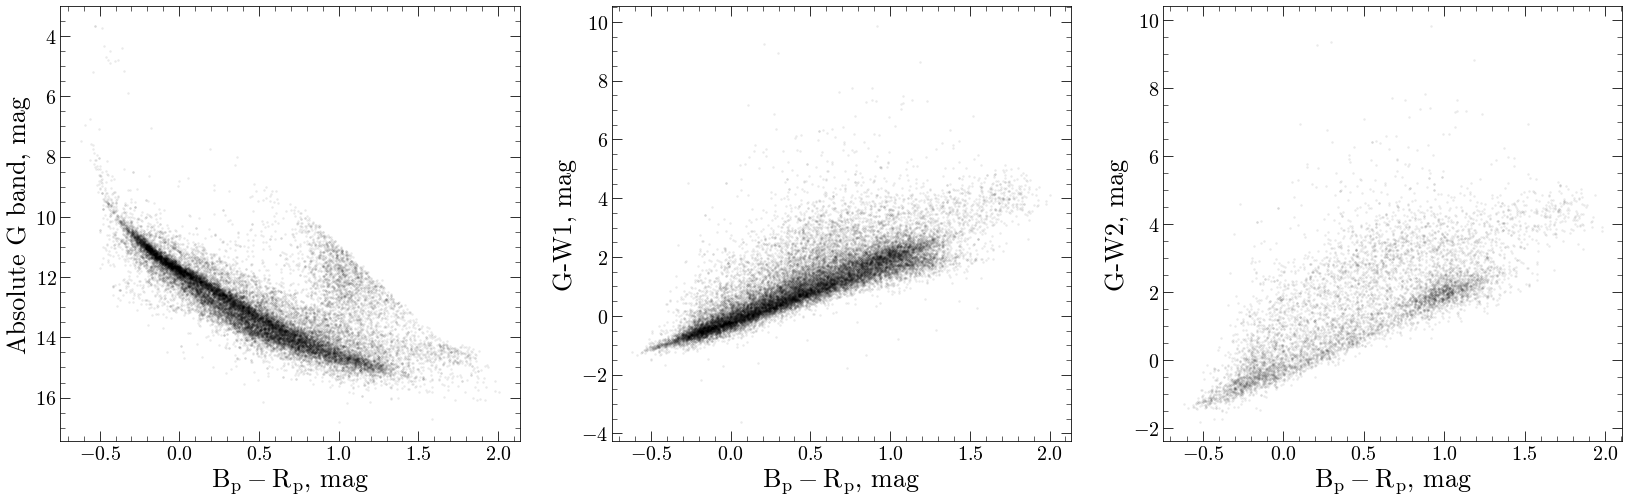

In [17]:
plt.figure(figsize=(28,8))

plt.subplot(1,3,1)

plt.scatter(catalog['bp_rp'], catalog['abs_g'], s = 3, c = 'k', alpha = 0.05)

plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('Absolute G band, mag')

plt.gca().invert_yaxis()

plt.subplot(1,3,2)

plt.scatter(catalog['bp_rp'], catalog['abs_g'] - catalog['abs_w1'], s = 3, c = 'k', alpha = 0.05)

plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('G-W1, mag')

plt.subplot(1,3,3)

plt.scatter(catalog['bp_rp'], catalog['abs_g'] - catalog['abs_w2'], s = 3, c = 'k', alpha = 0.05)

plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('G-W2, mag')

In [18]:
from pyphot import unit
import sys
sys.path.append('../corv/src')
import corv

base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

bp_rp = []
g_w1 = []
g_w2 = []

lib = pyphot.get_library()
filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP'], lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]

logg = 8
teffs = np.linspace(5000, 120000, 500)

for i in tqdm(range(len(teffs))):
    spec = tremblay((teffs[i], logg))
    
    fluxes = [filters[j].get_flux(base_wavl * unit['angstrom'], spec* unit['erg/s/cm**2/angstrom'], axis=1).to('erg/s/cm**2/angstrom').value for j in range(len(filters))]
    mags = [-2.5 * np.log10(fluxes[j]) - filters[j].Vega_zero_mag for j in range(len(filters))]
    
    bp_rp.append(mags[1] - mags[2])
    g_w1.append(mags[0] - mags[3])
    g_w2.append(mags[0] - mags[4])
    
bp_rp = list(reversed(bp_rp))
g_w1 = list(reversed(g_w1))
g_w2 = list(reversed(g_w2))

catalog['w1_diffs'] = (catalog['abs_g'] - catalog['abs_w1']) - np.interp(catalog['bp_rp'], bp_rp, g_w1)
catalog['w2_diffs'] = (catalog['abs_g'] - catalog['abs_w2']) - np.interp(catalog['bp_rp'], bp_rp, g_w2)

building montreal da model
could not find pickled WD models
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


100%|██████████| 500/500 [00:14<00:00, 33.63it/s]


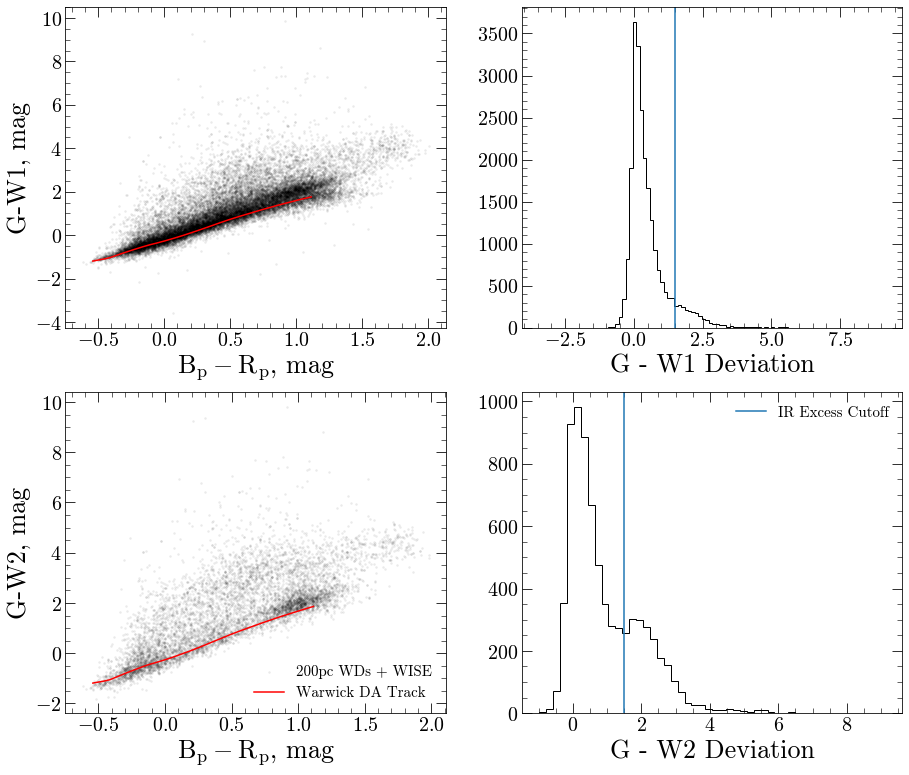

In [19]:
plt.figure(figsize=(15,13))

plt.subplot(2,2,1)

plt.scatter(catalog['bp_rp'], catalog['abs_g'] - catalog['abs_w1'], s = 3, c = 'k', alpha = 0.05)
plt.plot(bp_rp, g_w1, c='red', label='Warwick DA Track')

plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('G-W1, mag')

plt.subplot(2,2,2)

plt.hist(catalog[~np.isinf(catalog['w1_diffs'])]['w1_diffs'], color = 'k', histtype = 'step', bins = 100)
plt.axvline(x = 1.5)

plt.xlabel('G - W1 Deviation')

plt.subplot(2,2,3)

plt.scatter(catalog['bp_rp'], catalog['abs_g'] - catalog['abs_w2'], s = 3, c = 'k', alpha = 0.05, label = '200pc WDs + WISE')
plt.plot(bp_rp, g_w2, c='red', label='Warwick DA Track')

plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('G-W2, mag')
plt.legend(framealpha=0)

plt.subplot(2,2,4)

plt.hist(catalog[~np.isinf(catalog['w2_diffs'])]['w2_diffs'], color = 'k', histtype = 'step', bins = 50)
plt.axvline(x = 1.5, label = 'IR Excess Cutoff')

plt.xlabel('G - W2 Deviation')
plt.legend(framealpha=0)

#plt.savefig('ir_excess.png')

In [20]:
w1_mask = np.all([~np.isinf(catalog['w1_diffs']), catalog['w1_diffs'] > 1.5], axis = 0)
w2_mask = np.all([~np.isinf(catalog['w2_diffs']), catalog['w2_diffs'] > 1.5], axis = 0)

mask = np.any([w1_mask, w2_mask], axis=0)

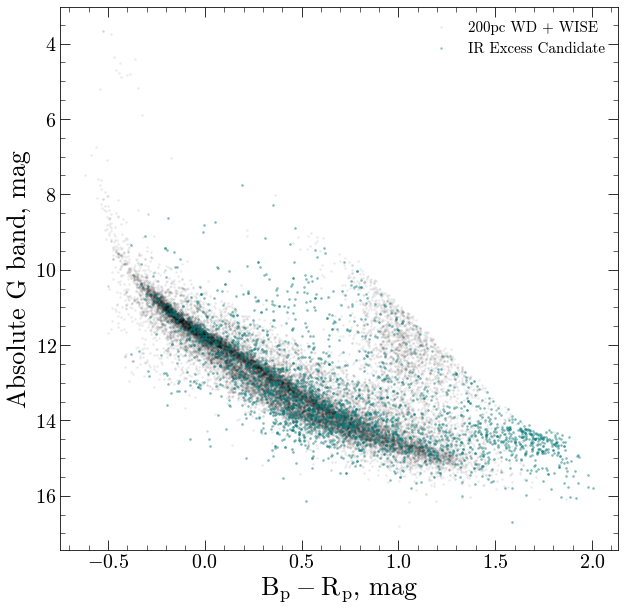

In [21]:
plt.figure(figsize=(10,10))


plt.scatter(catalog['bp_rp'], catalog['abs_g'], s = 3, c = 'k', alpha = 0.05, label = '200pc WD + WISE')
plt.scatter(catalog[mask]['bp_rp'], catalog[mask]['abs_g'], s = 3, c = 'teal', alpha = 0.3, label = 'IR Excess Candidate')


plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('Absolute G band, mag')

plt.legend(framealpha=0)

plt.gca().invert_yaxis()

In [22]:
len(catalog[mask])

2687

Text(0.5, 0, 'G - W2 Deviation')

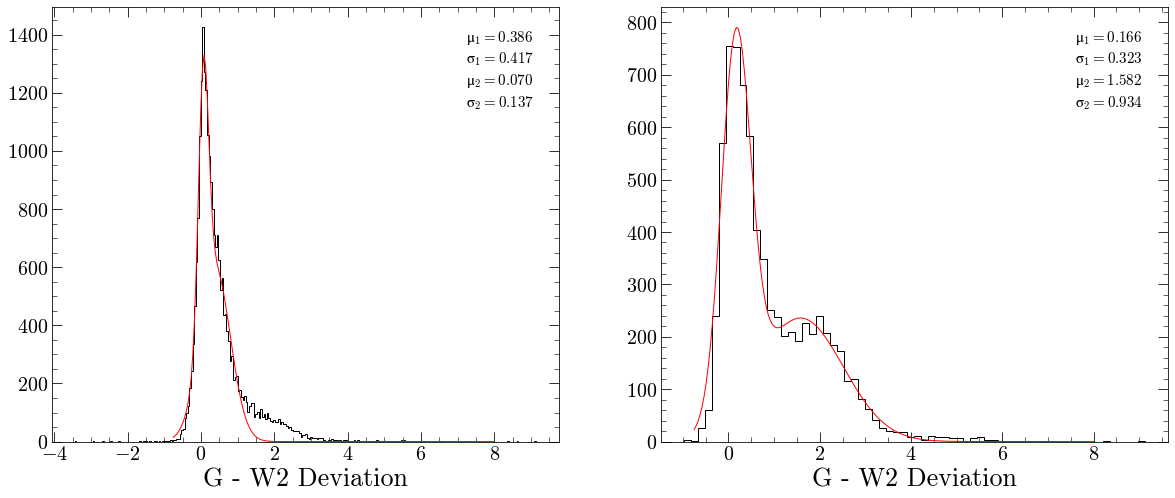

In [23]:
from scipy.optimize import leastsq

fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2) + p[3]*np.exp(-0.5*((x-p[4])/p[5])**2)
errfunc  = lambda p, x, y: (y - fitfunc(p, x))

init  = [10.0, 0.5, 5, 10.0, 0.5, 5]
domain = np.linspace(-0.75,8,200)

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)

n, bins, patches = plt.hist(catalog[~np.isinf(catalog['w1_diffs'])]['w1_diffs'], color = 'k', histtype='step')

x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]
init  = [20.0, 0.5, 5, 20.0, 4, 5]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='r', linewidth = 1)

plt.text(0.95, 0.95, r'$\mu_1 = %.3f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma_1 = %.3f$' % np.average( np.abs(c[2]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.85, r'$\mu_2 = %.3f$' % c[4] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.8, r'$\sigma_2 = %.3f$' % np.average( np.abs(c[5]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlabel('G - W2 Deviation')

plt.subplot(1,2,2)

n, bins, patches = plt.hist(catalog[~np.isinf(catalog['w2_diffs'])]['w2_diffs'], color = 'k', histtype='step')

x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]
init  = [20.0, 0.5, 5, 20.0, 0.5, 5]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='r', linewidth = 1)

plt.text(0.95, 0.95, r'$\mu_1 = %.3f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma_1 = %.3f$' % np.average( np.abs(c[2]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.85, r'$\mu_2 = %.3f$' % c[4] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.8, r'$\sigma_2 = %.3f$' % np.average( np.abs(c[5]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlabel('G - W2 Deviation')

In [36]:
w1_mask

array([False, False, False, ..., False, False, False])

In [42]:
catalog['w1_excess_flag'] = np.zeros(len(catalog))
catalog['w2_excess_flag'] = np.zeros(len(catalog))

for i in tqdm(range(len(catalog))):
    if w1_mask[i] == True:
        catalog['w1_excess_flag'][i] = 1
    if w2_mask[i] == True:
        catalog['w2_excess_flag'][i] = 1

100%|██████████| 23691/23691 [00:00<00:00, 419336.59it/s]


In [45]:
catalog.write('data/possible_ir_excess.fits', overwrite=True)